# Author
Written by Kwok Keith

https://github.com/kwokkeith/Data_Science_Project

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Define the helper methods

In [535]:
def load_data(base_path):
    """Loads PCA-transformed dataset (X_train, X_test, Y_train, Y_test)."""
    X_train = np.load(f"{base_path}/X_train.npy")
    X_test = np.load(f"{base_path}/X_test.npy")
    Y_train = np.load(f"{base_path}/Y_train.npy")
    Y_test = np.load(f"{base_path}/Y_test.npy")

    # Ensure X_train and X_test have 3 dimensions (samples, timesteps, features)
    if X_train.ndim == 4:
        print(f"Reshaping X_train from {X_train.shape} to {(X_train.shape[0], X_train.shape[1], -1)}")
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
    
    if X_test.ndim == 4:
        print(f"Reshaping X_test from {X_test.shape} to {(X_test.shape[0], X_test.shape[1], -1)}")
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)
    
    # Print dataset structure
    print(f"X_train shape: {X_train.shape}")  # (num_samples, time_steps, pca_values)
    print(f"X_test shape: {X_test.shape}")
    print(f"Y_train shape: {Y_train.shape}")  # (num_samples, num_classes)
    print(f"Y_test shape: {Y_test.shape}")

    return X_train, X_test, Y_train, Y_test

def plot_pca_over_time(X_train):
    """Plots PCA components over time for a single sequence."""
    sequence_idx = np.random.randint(0, X_train.shape[0])
    sample_sequence = X_train[sequence_idx]  # Shape: (timesteps, pca_components)

    plt.figure(figsize=(10, 6))
    for i in range(sample_sequence.shape[1]):
        plt.plot(sample_sequence[:, i], label=f"PCA {i+1}", alpha=0.7)

    plt.xlabel("Time Steps")
    plt.ylabel("PCA Component Value")
    plt.title("PCA Components Over Time for One Sequence")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_pca_scatter(X, title="PCA Scatter Plot"):
    """Plots PCA scatter in 2D."""
    X_flat = X.reshape(-1, X.shape[2])  # Flatten across time for PCA
    pca_2d = PCA(n_components=2)
    X_2d = pca_2d.fit_transform(X_flat)

    plt.figure(figsize=(8, 6))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c='blue', s=5, alpha=0.5)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_pca_3d_scatter(X, title="3D PCA Scatter Plot"):
    """Plots PCA scatter in 3D."""
    X_flat = X.reshape(-1, X.shape[2])  # Flatten across time for PCA
    pca_3d = PCA(n_components=3)
    X_3d = pca_3d.fit_transform(X_flat)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c='red', s=5, alpha=0.5)

    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")
    ax.set_zlabel("PCA 3")
    ax.set_title(title)
    plt.show()

def plot_label_distribution(Y_train, Y_test):
    """Plots label distribution for train and test sets."""
    train_counts = np.sum(Y_train, axis=0)
    test_counts = np.sum(Y_test, axis=0)
    labels = [f"Class {i}" for i in range(len(train_counts))]

    plt.figure(figsize=(10, 5))
    plt.bar(labels, train_counts, color="blue", alpha=0.6, label="Train")
    plt.bar(labels, test_counts, color="red", alpha=0.6, label="Test")
    
    plt.xlabel("Classes")
    plt.ylabel("Number of Samples")
    plt.title("Label Distribution in Train & Test Sets")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.show()

# Path to the pca dataset

In [536]:
# path = "./mp_data_processed/skip_1_testsize_20_3"
path = "./mp_data_generated_processed/skip_1_testsize_20_0"

In [537]:
X_train_raw, X_test_raw, Y_train_raw, Y_test_raw = load_data(path)

Reshaping X_train from (1296, 15, 554, 3) to (1296, 15, -1)
Reshaping X_test from (324, 15, 554, 3) to (324, 15, -1)
X_train shape: (1296, 15, 1662)
X_test shape: (324, 15, 1662)
Y_train shape: (1296, 5)
Y_test shape: (324, 5)


# Visualise Raw Keypoints

In [538]:
import matplotlib.pyplot as plt

def plot_2d_keypoints_matrix(X, sample_idx=0, num_rows=3, num_cols=5, action=""):
    """Plots a matrix of 2D keypoints over multiple frames."""
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, ax in enumerate(axes.flat):
        if i >= X.shape[1]:  # If more subplots than frames, break
            break

        sample_frame = X[sample_idx, i, :]  # Extract frame (flattened keypoints)
        num_keypoints = sample_frame.size // 3
        keypoints = sample_frame.reshape((num_keypoints, 3))  # Reshape to (num_keypoints, 3)

        ax.scatter(keypoints[:, 0], keypoints[:, 1], c="blue", s=10)
        ax.set_title(f"Frame {i+1}")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.invert_yaxis()  # Flip Y-axis to match camera perspective

    plt.suptitle(f"2D {action} Keypoints Over Time (Matrix View)", fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_keypoints_stacked(X, sample_idx=0, axis="xy"):
    """
    Plots keypoints stacked on top of each other to visualize smooth transitions.
    
    Parameters:
    - X: numpy array of shape (samples, timesteps, flattened keypoints).
    - sample_idx: Index of the sample to visualize.
    - axis: String specifying which axes to plot ('xy', 'xz', 'yz').
    """
    fig, ax = plt.subplots(figsize=(6, 10))

    num_frames = X.shape[1]

    for i in range(num_frames):
        sample_frame = X[sample_idx, i, :]  # Extract frame (flattened keypoints)
        num_keypoints = sample_frame.size // 3
        keypoints = sample_frame.reshape((num_keypoints, 3))  # Reshape to (num_keypoints, 3)

        if axis == "xy":
            ax.scatter(keypoints[:, 0], keypoints[:, 1], label=f"Frame {i+1}", alpha=0.5, s=10)
            ax.set_xlabel("X")
            ax.set_ylabel("Y")
        elif axis == "xz":
            ax.scatter(keypoints[:, 0], keypoints[:, 2], label=f"Frame {i+1}", alpha=0.5, s=10)
            ax.set_xlabel("X")
            ax.set_ylabel("Z")
        elif axis == "yz":
            ax.scatter(keypoints[:, 1], keypoints[:, 2], label=f"Frame {i+1}", alpha=0.5, s=10)
            ax.set_xlabel("Y")
            ax.set_ylabel("Z")
        else:
            raise ValueError("Invalid axis choice. Choose from 'xy', 'xz', or 'yz'.")

    ax.set_title(f"Stacked 2D Keypoints Over Time ({axis.upper()})")
    ax.invert_yaxis()  # Flip Y-axis to match camera perspective (except for XZ)
    ax.legend(loc="upper right", fontsize="small", ncol=2)
    ax.grid()

    plt.show()


def plot_keypoints_stacked_row(X, sample_idx=0, action=""):
    """
    Plots keypoints stacked on top of each other for 'xy', 'xz', and 'yz' views in a row.
    
    Parameters:
    - X: numpy array of shape (samples, timesteps, flattened keypoints).
    - sample_idx: Index of the sample to visualize.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes_titles = ["XY View", "XZ View", "YZ View"]
    axes_labels = [("X", "Y"), ("X", "Z"), ("Y", "Z")]
    axes_views = ["xy", "xz", "yz"]

    num_frames = X.shape[1]
    cmap = plt.get_cmap("viridis", num_frames)  # Color map for better frame distinction

    for ax, view, title, (xlabel, ylabel) in zip(axes, axes_views, axes_titles, axes_labels):
        for i in range(num_frames):
            sample_frame = X[sample_idx, i, :]  # Extract frame (flattened keypoints)
            num_keypoints = sample_frame.size // 3
            keypoints = sample_frame.reshape((num_keypoints, 3))  # Reshape to (num_keypoints, 3)

            if view == "xy":
                ax.scatter(keypoints[:, 0], keypoints[:, 1], c=[cmap(i)], label=f"Frame {i+1}", alpha=0.6, s=10)
            elif view == "xz":
                ax.scatter(keypoints[:, 0], keypoints[:, 2], c=[cmap(i)], label=f"Frame {i+1}", alpha=0.6, s=10)
            elif view == "yz":
                ax.scatter(keypoints[:, 1], keypoints[:, 2], c=[cmap(i)], label=f"Frame {i+1}", alpha=0.6, s=10)

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(f"Stacked {action} 2D Keypoints Over Time ({title})")
        ax.grid()
        if view != "xz":
            ax.invert_yaxis()  # Flip Y-axis to match camera perspective


def plot_two_samples_stacked(X, sample_idx1=0, sample_idx2=1):
    """
    Plots keypoints stacked on top of each other for two different samples to compare their motion,
    with the legend placed at the bottom.

    Parameters:
    - X: numpy array of shape (samples, timesteps, flattened keypoints).
    - sample_idx1: Index of the first sample.
    - sample_idx2: Index of the second sample.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes_titles = ["XY View", "XZ View", "YZ View"]
    axes_labels = [("X", "Y"), ("X", "Z"), ("Y", "Z")]
    axes_views = ["xy", "xz", "yz"]

    num_frames = X.shape[1]
    cmap1 = plt.get_cmap("Blues")  # Color map for first sample
    cmap2 = plt.get_cmap("Reds")   # Color map for second sample

    for ax, view, title, (xlabel, ylabel) in zip(axes, axes_views, axes_titles, axes_labels):
        for i in range(num_frames):
            # First sample
            sample_frame1 = X[sample_idx1, i, :]
            num_keypoints = sample_frame1.size // 3
            keypoints1 = sample_frame1.reshape((num_keypoints, 3))

            # Second sample
            sample_frame2 = X[sample_idx2, i, :]
            keypoints2 = sample_frame2.reshape((num_keypoints, 3))

            if view == "xy":
                ax.scatter(keypoints1[:, 0], keypoints1[:, 1], color=cmap1(i / num_frames), label=f"Frame {i+1}", alpha=0.6, s=10)
                ax.scatter(keypoints2[:, 0], keypoints2[:, 1], color=cmap2(i / num_frames), marker="x", alpha=0.6, s=10)
            elif view == "xz":
                ax.scatter(keypoints1[:, 0], keypoints1[:, 2], color=cmap1(i / num_frames), label=f"Frame {i+1}", alpha=0.6, s=10)
                ax.scatter(keypoints2[:, 0], keypoints2[:, 2], color=cmap2(i / num_frames), marker="x", alpha=0.6, s=10)
            elif view == "yz":
                ax.scatter(keypoints1[:, 1], keypoints1[:, 2], color=cmap1(i / num_frames), label=f"Frame {i+1}", alpha=0.6, s=10)
                ax.scatter(keypoints2[:, 1], keypoints2[:, 2], color=cmap2(i / num_frames), marker="x", alpha=0.6, s=10)

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(f"Comparison of Two Samples ({title})")
        ax.grid()
        if view != "xz":
            ax.invert_yaxis()

    # Add a global legend at the bottom
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="blue", markersize=8, label="Sample 1"),
        plt.Line2D([0], [0], marker='x', color='w', markerfacecolor="red", markersize=8, label="Sample 2")
    ]
    fig.legend(handles=handles, loc="lower center", ncol=2, fontsize="small", title="Sample Legend", bbox_to_anchor=(0.5, -0.05))

In [539]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_keypoints_matrix(X, sample_idx=0, num_rows=3, num_cols=5, action=""):
    """Plots a matrix of 3D keypoints over multiple frames."""
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10), subplot_kw={'projection': '3d'})

    for i, ax in enumerate(axes.flat):
        if i >= X.shape[1]:  # If more subplots than frames, break
            break

        sample_frame = X[sample_idx, i, :]  # Extract frame (flattened keypoints)
        num_keypoints = sample_frame.size // 3
        keypoints = sample_frame.reshape((num_keypoints, 3))  # Reshape to (num_keypoints, 3)

        ax.scatter(keypoints[:, 0], keypoints[:, 1], keypoints[:, 2], c="blue", s=10)
        ax.set_title(f"Frame {i+1}")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")

        # Add more minor ticks for better visualization
        ax.xaxis.set_major_locator(plt.MaxNLocator(4))
        ax.yaxis.set_major_locator(plt.MaxNLocator(4))
        ax.zaxis.set_major_locator(plt.MaxNLocator(4))

        ax.xaxis.set_minor_locator(plt.MaxNLocator(8))
        ax.yaxis.set_minor_locator(plt.MaxNLocator(8))
        ax.zaxis.set_minor_locator(plt.MaxNLocator(8))

    plt.suptitle(f"3D {action} Keypoints Over Time (Matrix View)", fontsize=16)
    plt.tight_layout()
    plt.show()

In [540]:
# Sample id to visualise
# 4 -> what
# 0 -> hello
# 2 -> name
# 3 -> your
# 7 -> my
sample_idx = 4

In [541]:
# Assuming these are your ASL action labels
asl_labels = ["hello", "my", "name", "what", "your"]

# Convert one-hot encoding back to class index
class_index = np.argmax(Y_train_raw[sample_idx])  # Get the index of the 1

# Get the actual label
asl_action = asl_labels[class_index]
print(f"Sample {sample_idx} corresponds to the action: {asl_action}")

Sample 4 corresponds to the action: my


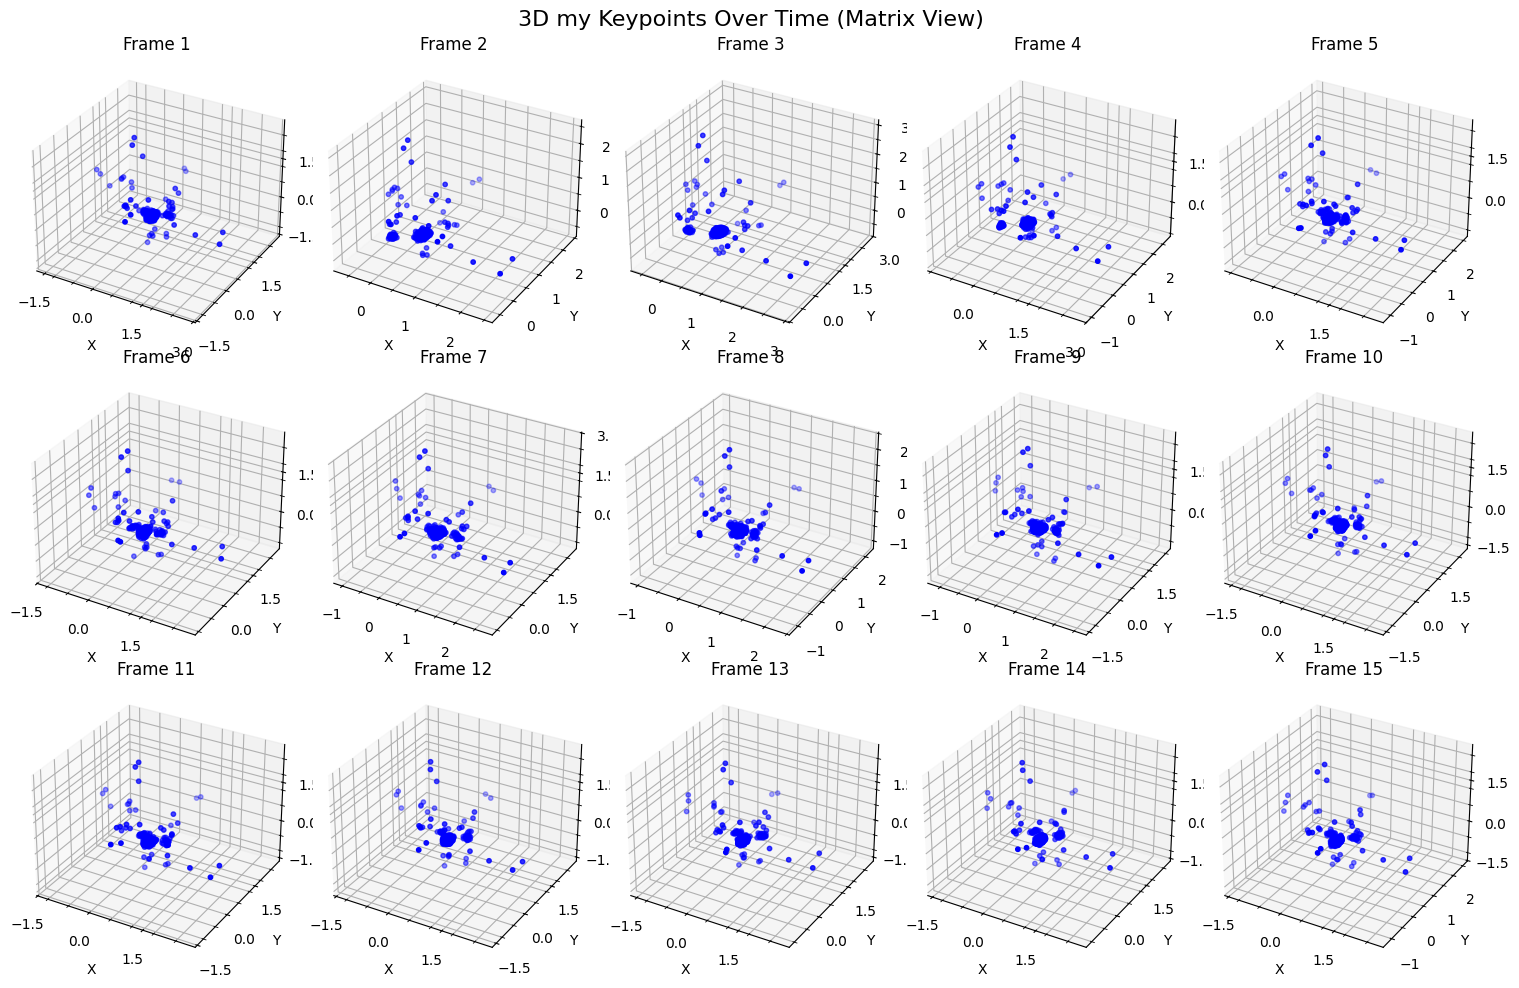

In [542]:
plot_3d_keypoints_matrix(X_train_raw, sample_idx=0, num_rows=3, num_cols=5, action=asl_action)

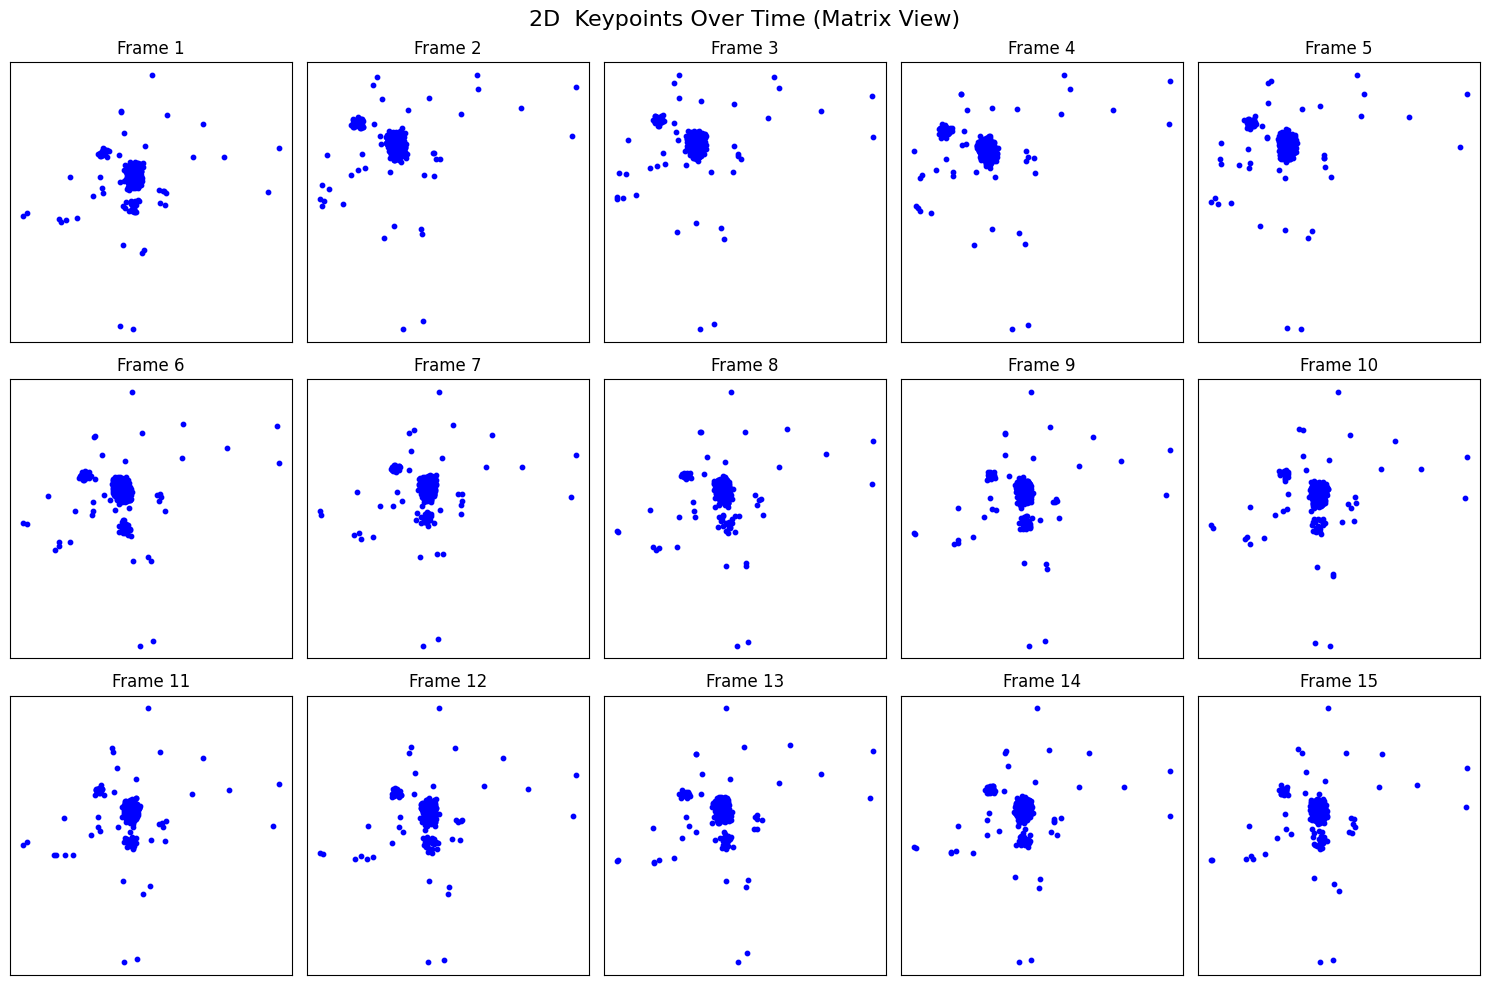

In [543]:
plot_2d_keypoints_matrix(X_train_raw, sample_idx, num_rows=3, num_cols=5)

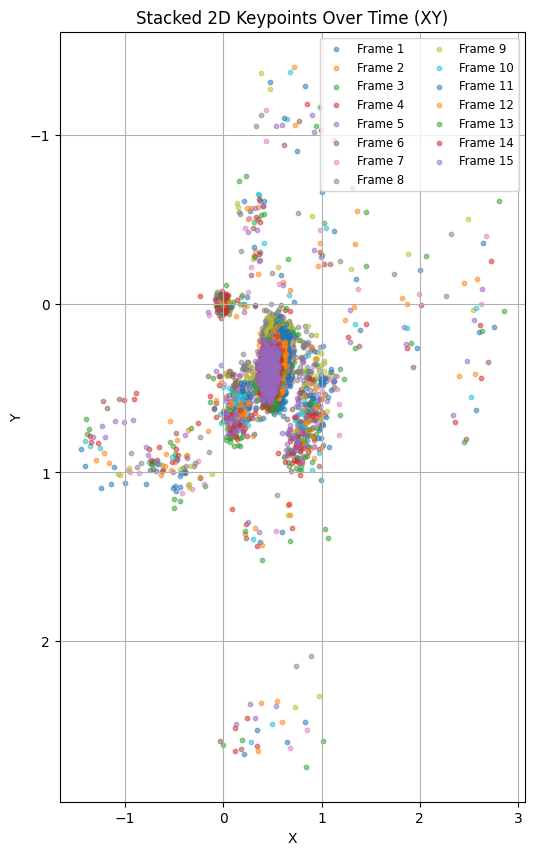

In [544]:
# Plot stacked keypoints for 'xy' view
plot_keypoints_stacked(X_train_raw, sample_idx=0, axis="xy")

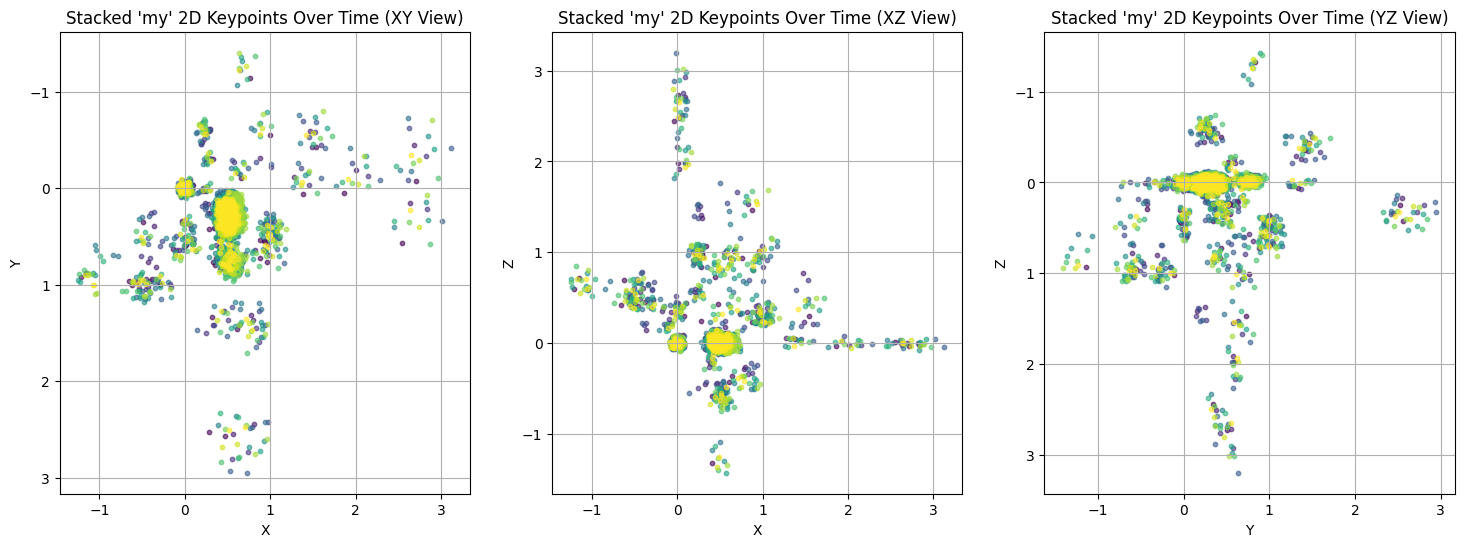

In [545]:
# Plot stacked keypoints in all views
plot_keypoints_stacked_row(X_train_raw, sample_idx, action=f"'{asl_action}'")

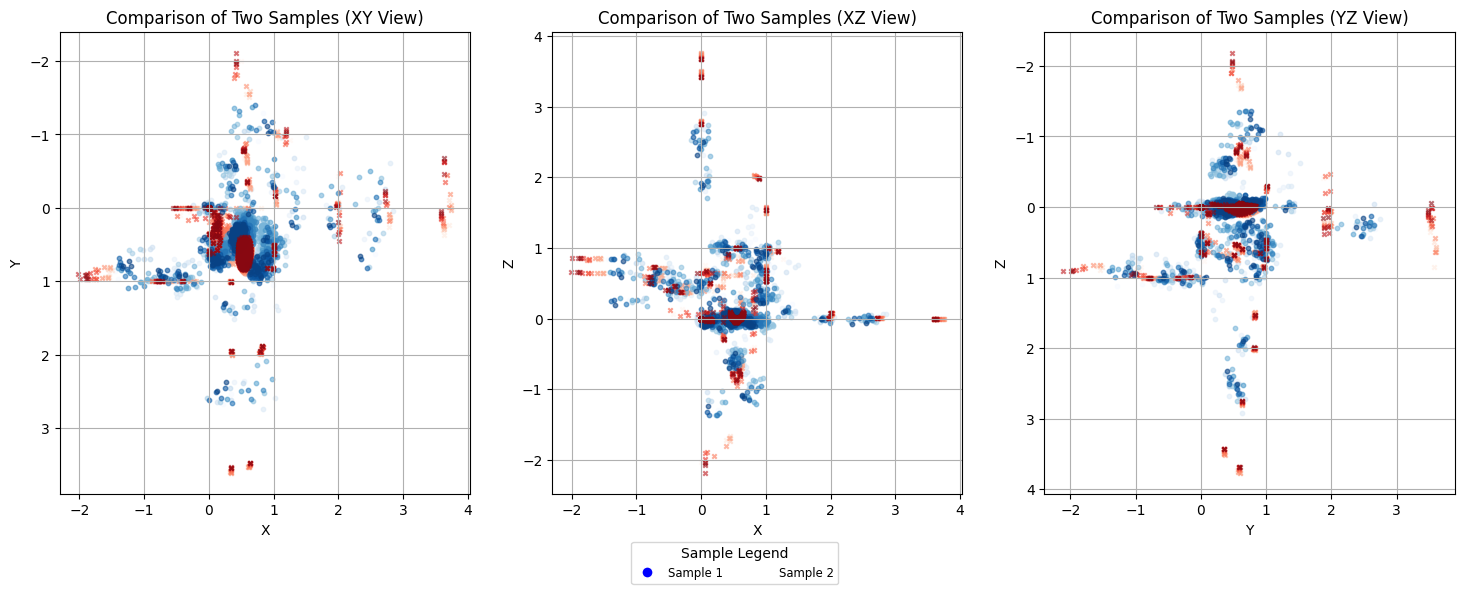

In [546]:
plot_two_samples_stacked(X_train_raw, sample_idx1=0, sample_idx2=3)

# Create PCA

## Helper Functions

In [547]:
from sklearn.decomposition import PCA

def apply_pca(X, num_components=50):
    """Applies PCA to reduce dimensionality."""
    num_samples, num_timesteps, num_features = X.shape
    X_reshaped = X.reshape(num_samples * num_timesteps, num_features)  # Flatten for PCA

    pca = PCA(n_components=num_components)
    X_pca = pca.fit_transform(X_reshaped)

    explained_variance = np.sum(pca.explained_variance_ratio_) * 100
    print(f"PCA Retained Variance: {explained_variance:.2f}%")

    X_pca = X_pca.reshape(num_samples, num_timesteps, num_components)  # Reshape back
    return X_pca, pca

# Visualizing PCA components over time
def plot_pca_over_time(X, sample_idx=0, action=""):
    """Plots PCA components over time for a single ASL phrase."""
    sample_sequence = X[sample_idx]  # (timesteps, pca_values)

    plt.figure(figsize=(10, 6))
    for i in range(sample_sequence.shape[1]):
        plt.plot(sample_sequence[:, i], alpha=0.7)

    plt.xlabel("Time Steps")
    plt.ylabel("PCA Component Value")
    plt.title(f"PCA Components Over Time for '{action}' ASL Gesture")
    plt.grid(True)
    plt.show()

## Generating PCA Dataset

In [548]:
# Apply PCA to train and test sets
num_components = 10
X_train_pca, pca = apply_pca(X_train_raw, num_components)
X_test_pca = pca.transform(X_test_raw.reshape(X_test_raw.shape[0] * X_test_raw.shape[1], -1)).reshape(X_test_raw.shape[0], X_test_raw.shape[1], num_components)

PCA Retained Variance: 92.21%


## Visualising PCA

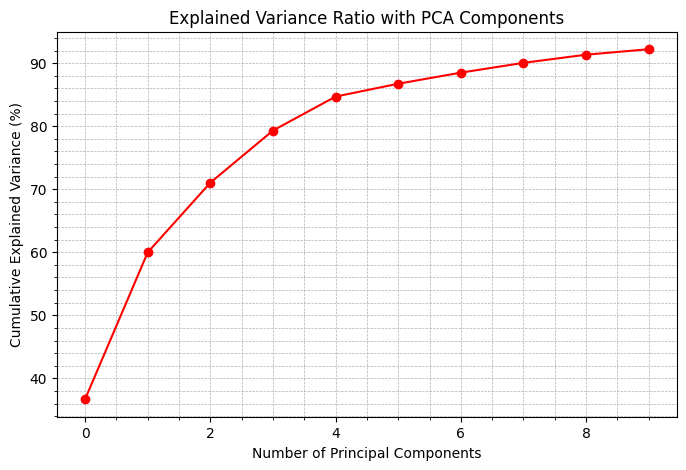

In [549]:
# Plot explained variance ratio with minor grid lines
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_) * 100, marker='o', linestyle='-', color='r')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.title("Explained Variance Ratio with PCA Components")

# Add major and minor grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()

plt.show()

In [550]:
# Sample id to visualise
# 4 -> what
# 0 -> hello
# 2 -> name
# 3 -> your
# 7 -> my
sample_idx_list = [4,0,2,3,7]


print(f"Sample {sample_idx} corresponds to the action: {asl_action}")

Sample 4 corresponds to the action: my


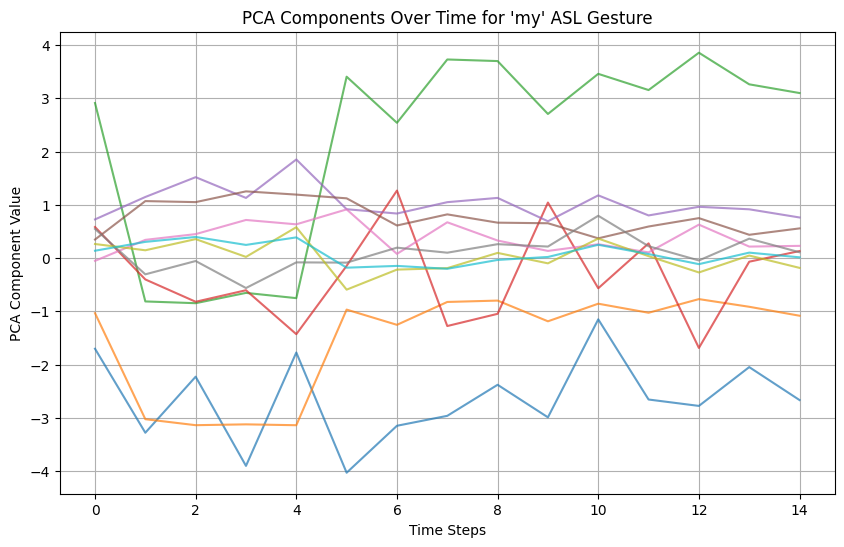

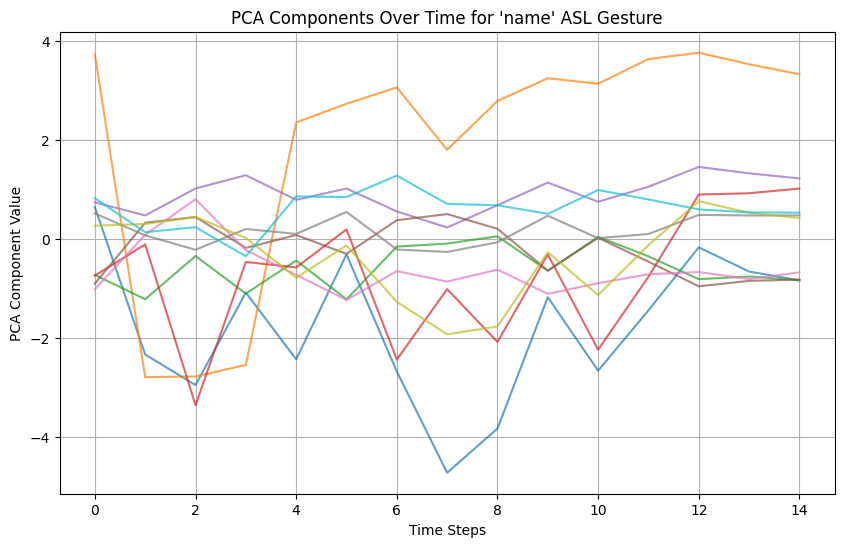

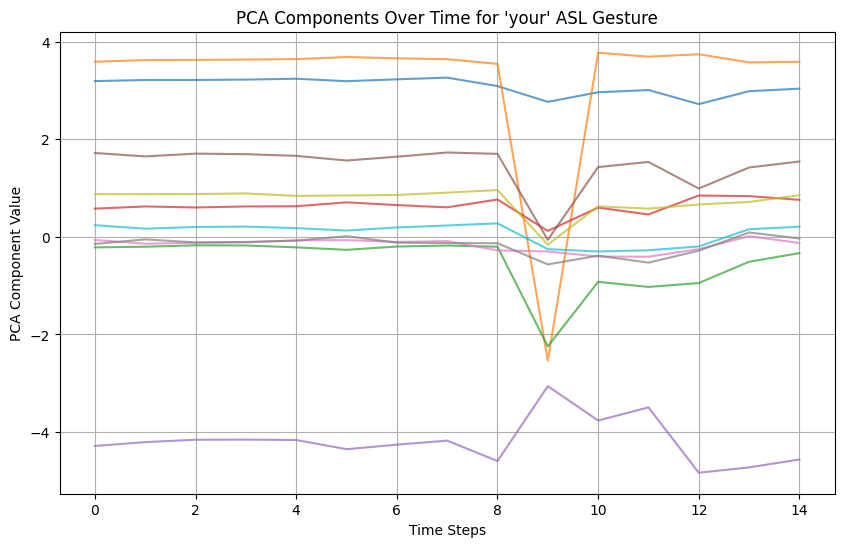

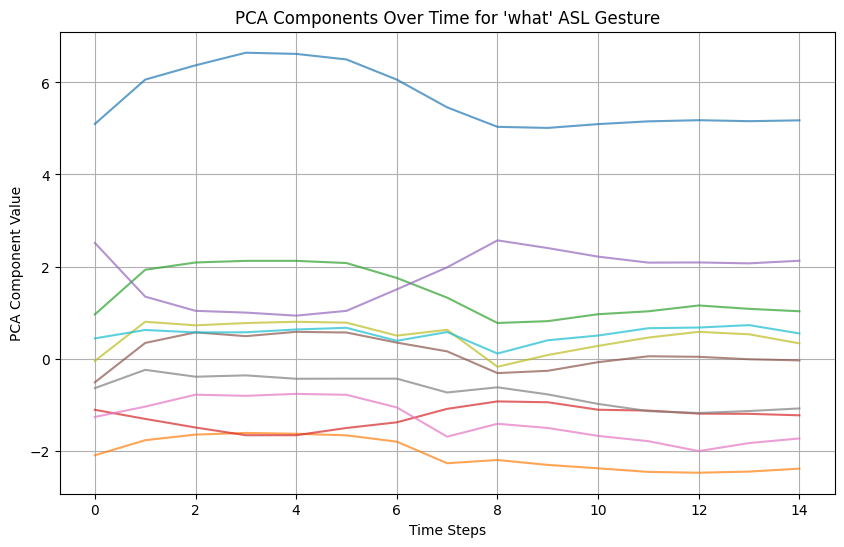

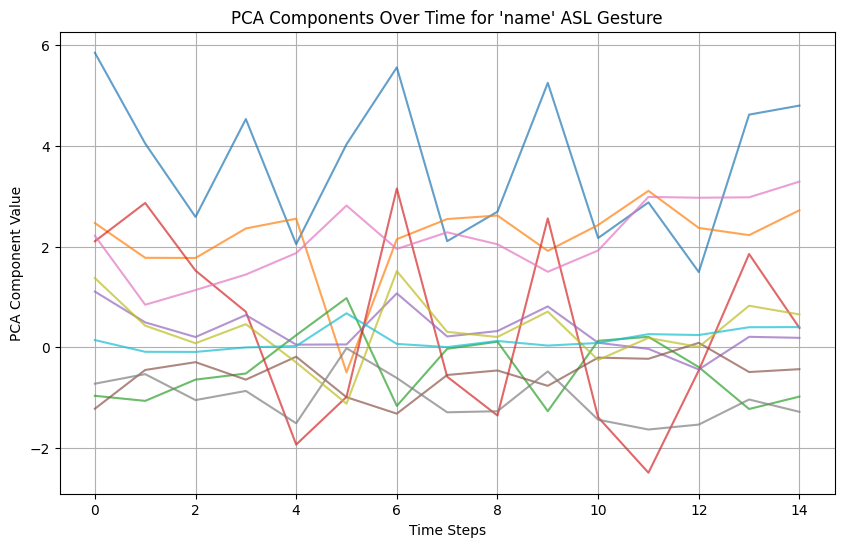

In [551]:
# Visualize PCA-transformed ASL movement
for sample_idx in sample_idx_list:
    # Assuming these are your ASL action labels
    asl_labels = ["hello", "my", "name", "what", "your"]

    # Convert one-hot encoding back to class index
    class_index = np.argmax(Y_train_raw[sample_idx])  # Get the index of the 1

    # Get the actual label
    asl_action = asl_labels[class_index]
    plot_pca_over_time(X_train_pca, sample_idx, asl_action)


In [552]:
# Extract labels from one-hot encoding
asl_labels = ["hello", "my", "name", "what", "your"]
Y_train_labels = np.argmax(Y_train_raw, axis=1)  # Convert one-hot to class indices

# Function to visualize PCA components over time for one sample of each ASL action
def plot_pca_over_time_per_action_unique(X_pca, Y_labels, num_components=5):
    """Plots PCA components over time for one sample of each ASL action."""
    plt.figure(figsize=(12, 8))

    for action_idx, action in enumerate(asl_labels):
        # Select the first sample of this action
        sample_idx = np.where(Y_labels == action_idx)[0][0]
        sample_pca_values = X_pca[sample_idx]  # Shape (timesteps, num_components)

        for i in range(num_components):
            plt.plot(sample_pca_values[:, i], label=f"{action} - PC {i+1}" if i == 0 else None, alpha=0.8)

    plt.xlabel("Time Steps")
    plt.ylabel("PCA Component Value")
    plt.title("PCA Components Over Time for One Sample of Each ASL Action")
    plt.legend(loc="upper right", fontsize="small", ncol=2)
    plt.grid(True)
    plt.show()

In [553]:
def plot_pca_per_component_per_action(X_pca, Y_labels, num_components=5):
    """Creates a matrix of plots showing each PCA component over time for each ASL action."""
    num_actions = len(asl_labels)
    
    fig, axes = plt.subplots(num_actions, num_components, figsize=(15, 12), sharex=True, sharey=True)

    for action_idx, action in enumerate(asl_labels):
        # Select the first sample of this action
        sample_idx = np.where(Y_labels == action_idx)[0][0]
        sample_pca_values = X_pca[sample_idx]  # Shape (timesteps, num_components)

        for pc in range(num_components):
            ax = axes[action_idx, pc]
            ax.plot(sample_pca_values[:, pc], label=f"PC {pc+1}", alpha=0.8)

            if action_idx == 0:
                ax.set_title(f"PCA {pc+1}")

            if pc == 0:
                ax.set_ylabel(f"{action}")

            ax.grid(True)

    fig.suptitle("PCA Components Over Time for Each ASL Action", fontsize=16)
    plt.xlabel("Time Steps")
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()



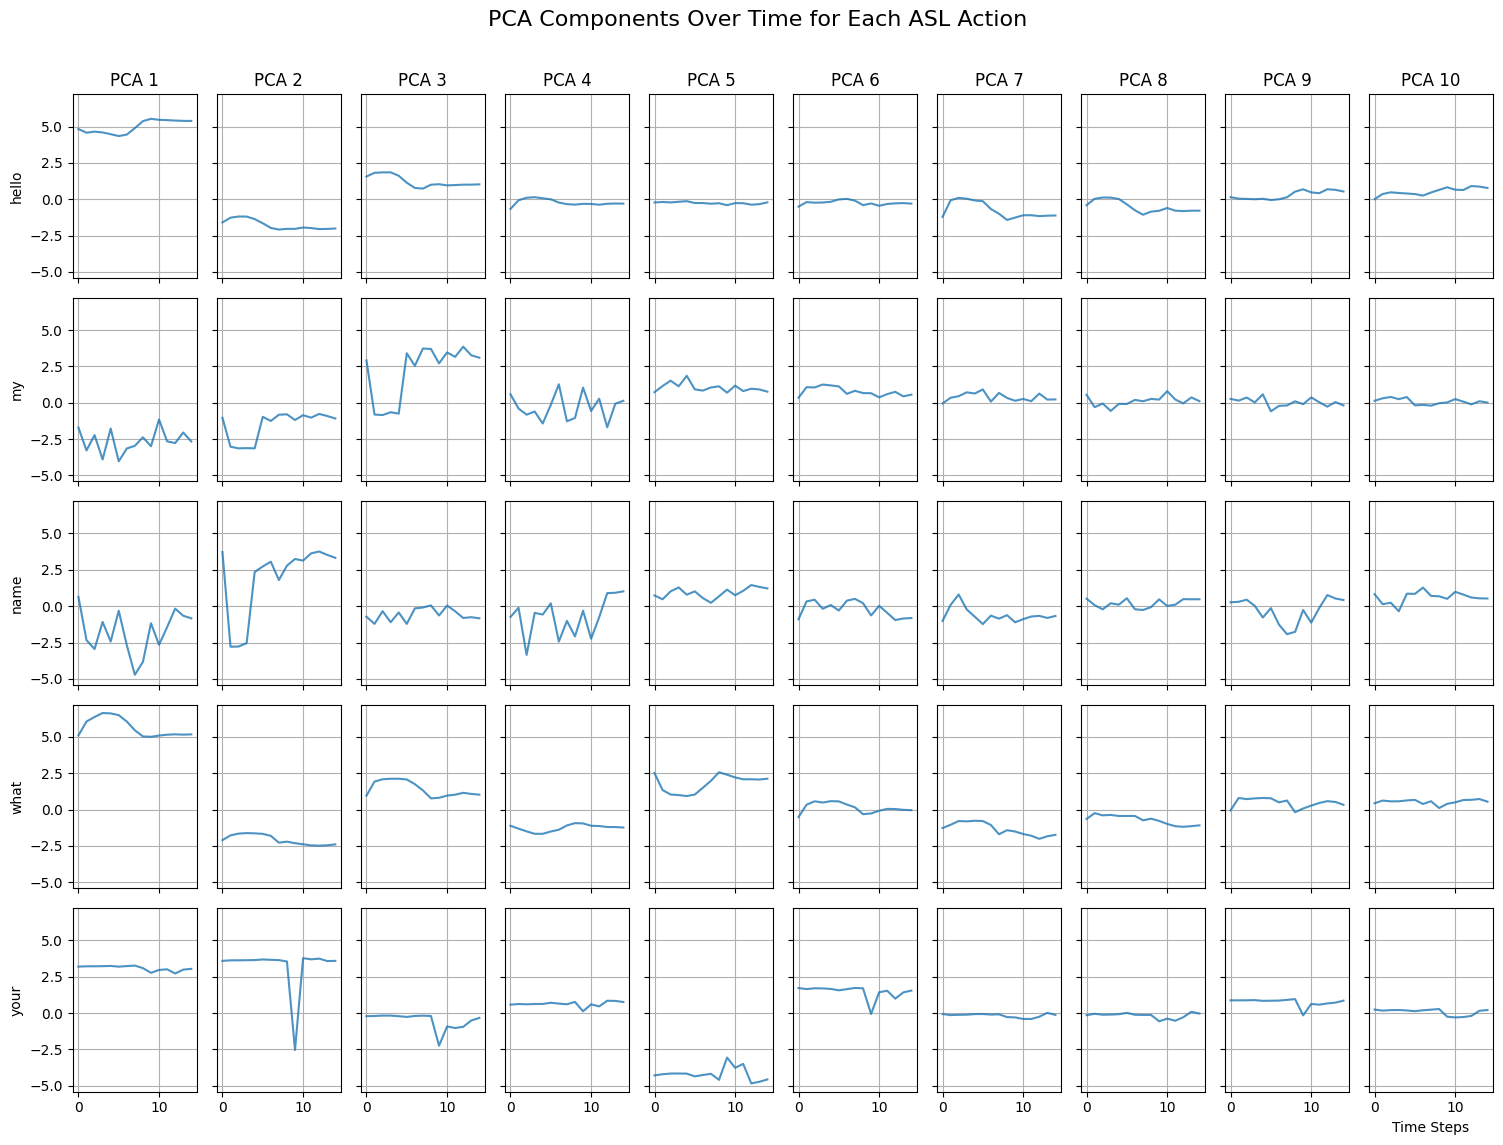

In [554]:
# Visualize PCA components over time in a matrix format
plot_pca_per_component_per_action(X_train_pca, Y_train_labels, num_components)

# Compare with raw data

In [509]:
# Function to compare raw vs PCA-transformed data over time
def compare_raw_vs_pca(X_raw, X_pca, sample_idx=0, num_components=5):
    """Compares raw keypoints vs. PCA features over time."""
    sample_sequence_raw = X_raw[sample_idx, :, :num_components]  # First few raw features
    sample_sequence_pca = X_pca[sample_idx]  # PCA components

    plt.figure(figsize=(12, 6))

    for i in range(num_components):
        plt.plot(sample_sequence_raw[:, i], linestyle="dashed", label=f"Raw Feature {i+1}", alpha=0.6)
        plt.plot(sample_sequence_pca[:, i], linestyle="solid", label=f"PCA {i+1}", alpha=0.8)

    plt.xlabel("Time Steps")
    plt.ylabel("Feature Value")
    plt.title("Raw Keypoints vs. PCA Over Time")
    plt.legend(loc="upper right", fontsize="small", ncol=2)
    plt.grid(True)
    plt.show()

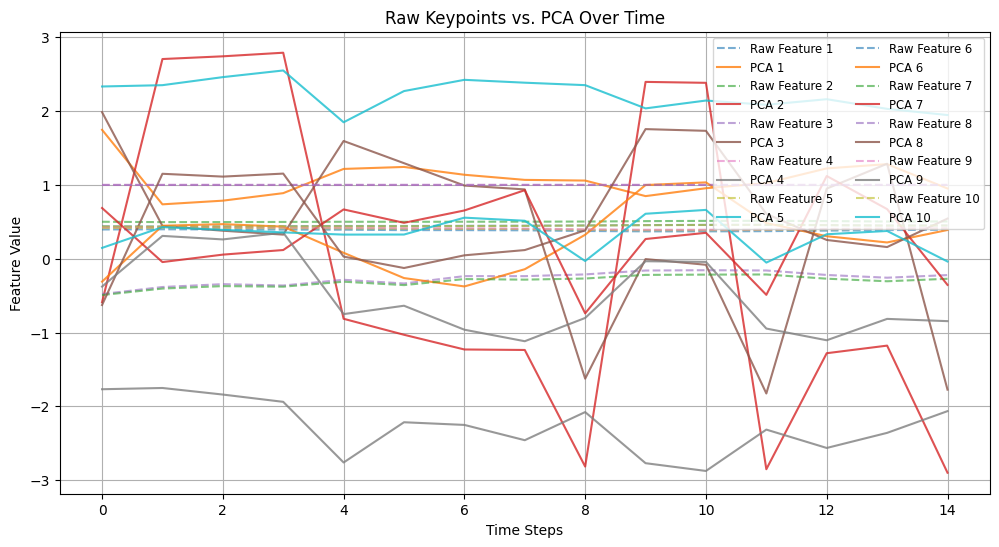

In [511]:
# Compare raw vs PCA for the first few components
compare_raw_vs_pca(X_train_raw, X_train_pca, sample_idx, num_components=10)

In [ ]:
plot_pca_over_time(X_train)

print("Plotting 2D PCA scatter for X_train...")
plot_pca_scatter(X_train, title="2D PCA Scatter (Train)")

print("Plotting 3D PCA scatter for X_train...")
plot_pca_3d_scatter(X_train, title="3D PCA Scatter (Train)")

print("Plotting 2D PCA scatter for X_test...")
plot_pca_scatter(X_test, title="2D PCA Scatter (Test)")

print("Plotting 3D PCA scatter for X_test...")
plot_pca_3d_scatter(X_test, title="3D PCA Scatter (Test)")

print("Plotting label distribution...")
plot_label_distribution(Y_train, Y_test)